In [1]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [2]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=2     # which GPU to use
plot=False # Plot Intermediate results
sigma=10.0   # Initial model smoothness  

# Inversion parameters
num_batches = 2
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 15
dx = 10
dt = 0.001
nt = 4001
num_shots = 20
num_receivers_per_shot = 250
plot = True

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [3]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
from sklearn.feature_extraction import image
from skimage.transform import resize

In [4]:
vp = np.fromfile('../seam_vp_true_final_toppad_nx_439_nz_143_d_0.05.dir',dtype='float32',count=-1)

In [5]:
vp_true = np.ascontiguousarray(np.reshape(vp, (143, -1), order='F'))
vp_true = vp_true*1000

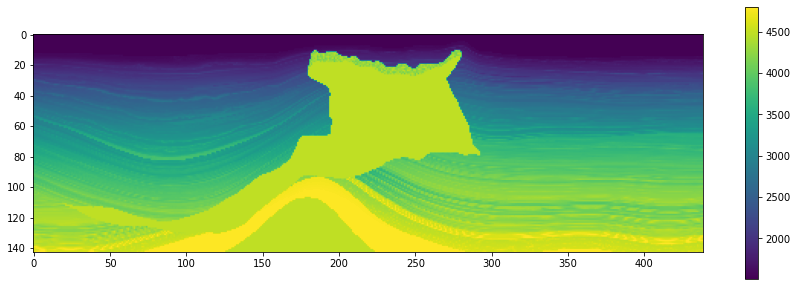

In [6]:
plt.figure(figsize=(15, 5))
plt.imshow(vp_true)
plt.colorbar()

In [7]:
np.min(vp_true)

1510.0

In [8]:
np.max(vp_true)

4800.0

In [9]:
bigm = np.zeros((100,250))
mat = vp_true
mat = resize(mat,(100,200),anti_aliasing=True)
bigm[:,25:225] = mat
bigm[:,0:25] = np.expand_dims(mat[:,0],axis=1)
bigm[:,225:250] = np.expand_dims(mat[:,199],axis=1)
mat = bigm
#mat = np.loadtxt('marmhard2.dat')
#mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
#RB Get model size
ny = np.size(mat,1);
nz = np.size(mat,0);
#RB compute true model mean value and width for future model normalization
max1=np.max(mat)
min1=np.min(mat)
med=(max1+min1)/2.
wid=(max1-min1)/2.
mat = bigm

In [10]:
wb = 0*mat
wb[(mat==1510)]=1

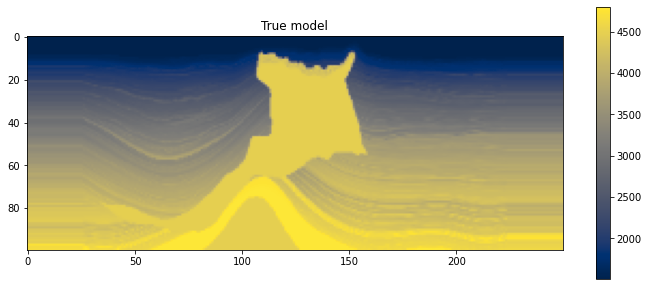

In [11]:
if plot==True:
    plt.figure(figsize=(12, 5))
    plt.imshow(mat,vmin=min1,vmax=max1, aspect=1,cmap='cividis')
    plt.title('True model')
    plt.colorbar()

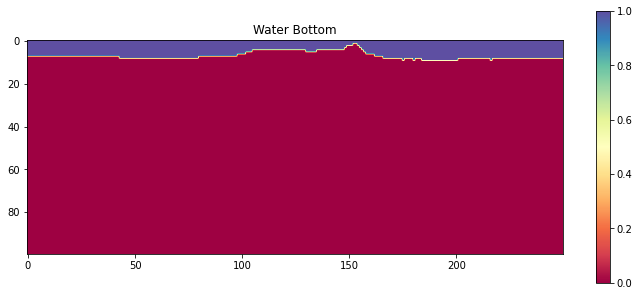

In [12]:
if plot==True:
    plt.figure(figsize=(12, 5))
    plt.imshow(wb,aspect=1,cmap='Spectral')
    plt.title('Water Bottom')
    plt.colorbar()

In [13]:
nnz = np.zeros(250)
for i in range(250):
    nnz[i] = np.max(np.nonzero(wb[:,i]))

In [14]:
np.max(mat)

4800.0

In [15]:
#RB Open file to write results
f = open('marmsm_Mod8_log.txt','a+')
writer = csv.writer(f)

#RB Write header
fields=['Epoch','it','loss.item','epoch_loss','it_lap','epoch_lap']
writer.writerow(fields)
f.flush()
os.fsync(f)

In [16]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [17]:
# Set parameters
num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)

ny= 250 nz= 100 nt= 4001 dx= 10 freq= 15
shots= 20 recs/shot= 250 ds= 125.0 dr= 10.0


In [311]:
np.linspace(0, 2000, 18)

array([   0.        ,  117.64705882,  235.29411765,  352.94117647,
        470.58823529,  588.23529412,  705.88235294,  823.52941176,
        941.17647059, 1058.82352941, 1176.47058824, 1294.11764706,
       1411.76470588, 1529.41176471, 1647.05882353, 1764.70588235,
       1882.35294118, 2000.        ])

In [312]:
source_spacing

125.0

In [313]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
#x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
x_s[:,0,1] = torch.linspace(0,(ny-1)*dx,num_shots)
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
for i in range(250):
    x_r[0,i,0] = nnz[i]*dx  
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)
x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [314]:
np.shape(source_amplitudes_true)

torch.Size([4001, 20, 1])

In [315]:
#RB Generate a cte velocy model (with water velocity)
mat2 = np.ones((nz,ny),np.float32)*1510.

mat2[nz-1,int(ny/2)]=max1  # put a pixel with true upper velocity to fix a propagator problem

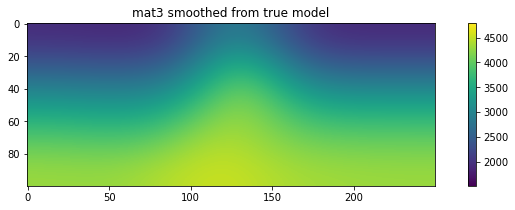

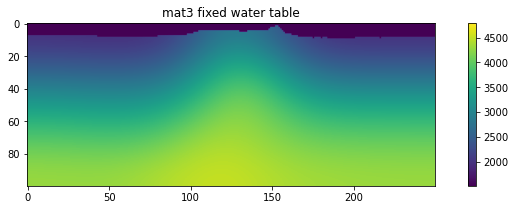

In [316]:
#RB Create a smoothed model

#RB start with true model
mat3 = np.copy(mat)
#RB Filter image heavly
mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=20) #5%,10%

#for i in range(201):
#    mat3[:,i] = scipy.ndimage.gaussian_filter1d(mat3[:,i],sigma=20)
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 smoothed from true model')
    plt.colorbar()

    
#mat3 = 2200*np.ones(np.shape(mat))
#RB Force water table to be 1500 m/s (avoid imperfect direct wav removal)    
#mat3[0:26,:]=1500.
mat3[(mat==1510)] = 1510
#mat3[27:-1,:]=2800.
#RB Plot model
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat3,vmin=min1,vmax=max1)
    plt.title('mat3 fixed water table')
    plt.colorbar()

#RB We may want to smooth the water table transition
#RB but I think it's a bad idea (not tested)
# mat3 = scipy.ndimage.gaussian_filter(mat3,sigma=4)

#RB Optionally we may import a initial model from file
#filename='Marm151_401_smooth.mat'
#mat3=scipy.io.loadmat(filename)['vel0']

#RB Ensure that the initial model has the same range of the true model by
#RB forcing one of its slowest pixel to have the true's model lower velocity and
#RB forcing one of its fastest pixel to have the true's model upper velocity
#RB find max & min values of mat3
smin=np.min(mat3)
smax=np.max(mat3)
indmin = np.where(mat3==smin)
indmax = np.where(mat3==smax)
# Take first pixel with minimum velocity and force it to true's model minimum velocity
mat3[indmin[0][0],indmin[1][0]]=min1
# Take first pixel with maximum velocity and force it to true's model maximum velocity
mat3[indmax[0][0],indmax[1][0]]=max1

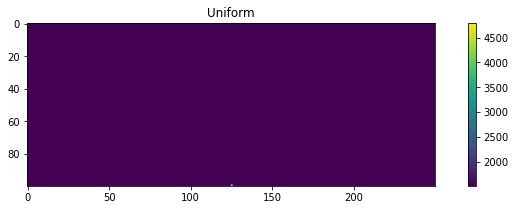

In [317]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat2,vmin=min1,vmax=max1, aspect=1)
    plt.title('Uniform')
    plt.colorbar()

In [318]:
#RB Convert models to PyTorch Tensors
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
model_cte = torch.Tensor(mat2) # Convert to a PyTorch Tensor

In [319]:
###### Create 'true' data 
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()
seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
#seis = seis.swapaxes(1,2)
#seis = seis.swapaxes(0,1)
#receiver_amplitudes_all = receiver_amplitudes_all.swapaxes(1,2)

In [320]:
#seis = seis + np.random.normal(seis,0.07*np.std(seis))

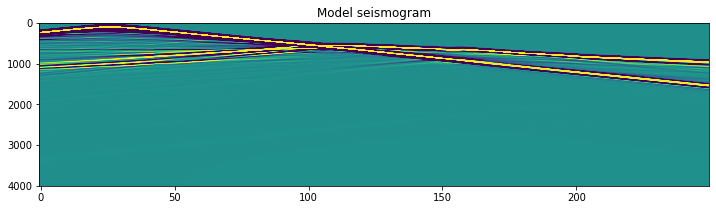

In [321]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(seis[:,2,:],vmin=-.05,vmax=.05, aspect='auto')
    
    plt.title('Model seismogram')

In [322]:
# Create direct arrivals data
prop2 = deepwave.scalar.Propagator({'vp': model_cte.to(device)}, dx)
receiver_amplitudes_cte = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [323]:
np.min(mat)

1510.0

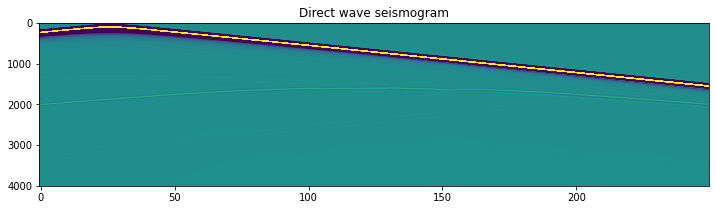

In [324]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_cte[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Direct wave seismogram')

In [325]:
# Exclude direct waves from true data (they don't bring info from subsurface)
receiver_amplitudes_nod = receiver_amplitudes_all - receiver_amplitudes_cte
seis=np.squeeze(receiver_amplitudes_nod.cpu().detach().numpy())
np.std(seis)

0.20804419

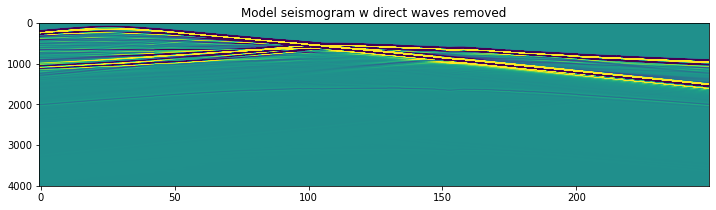

In [326]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(seis[:,2,:],vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram w direct waves removed')

In [327]:
seis = seis + np.random.normal(seis,np.std(seis))

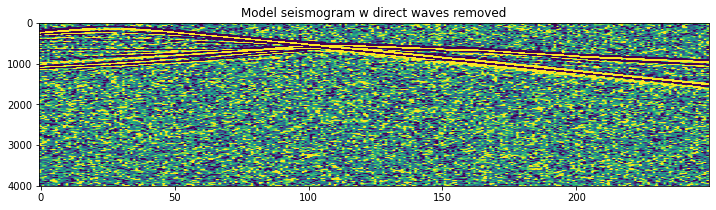

In [328]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(seis[:,2,:],vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram w direct waves removed')

In [329]:
receiver_amplitudes_true = receiver_amplitudes_all

In [330]:
#RB Normalize initial model to (-1,1) range
#model_init = (mat3-med)/wid
#RB_No_normalization
model_init = mat3

In [331]:
# Convert to Pytorch tensor
#model_init = torch.from_numpy(np.float32(model_init))
model_init = torch.Tensor(model_init)

# Make a copy so at the end we can see how far we came from the initial model
model = model_init.clone()
model = model.to(device)
model.requires_grad = True

In [332]:
#RB AS I am not inverting for source, I could just do
#RB source_amplitudes = source_amplitudes_true.clone().to(device)
#RB instead of all code below

# Create initial guess source amplitude for inversion
# I will assume that the true source amplitude is the same for every shot
# so I will just create one source amplitude, and PyTorch will backpropagate
# updates to it from every shot
source_amplitudes_init = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1))
source_amplitudes = source_amplitudes_init.clone()
source_amplitudes = source_amplitudes.to(device)
#source_amplitudes.requires_grad_(); # Alternative way of requiring gradient

In [333]:
# To demonstrate chaining operations, during the inversion I will normalise the
# predicted receiver amplitudes so that each trace has a maximum value of 1.
# This will be compared (in the cost function) with the true data that has been
# similarly scaled. I apply that scaling to the true data now.
# This sort of scaling might be useful for real data where the absolute
# amplitudes are often not meaningful.
rcv_amps_true_max, _ = receiver_amplitudes_true.max(dim=0, keepdim=True)
rcv_amps_true_norm = receiver_amplitudes_true / rcv_amps_true_max

In [334]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/')

          
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainD')

os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testA')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testB')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testC')
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainD')

os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testA')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testB')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testC')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testD')

0

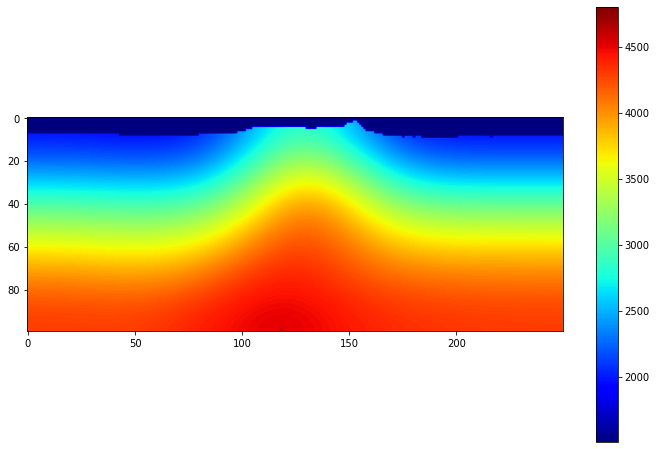

In [335]:
plt.figure(figsize=(12, 8))
plt.imshow(mat3,vmin=1510,vmax=4800,cmap='jet')
plt.colorbar()

In [336]:
seis = seis.swapaxes(0,1)
#mat3 = 2200*np.ones(np.shape(mat))
#mat3[0:26,:] = 1500
A = seis
B = mat
C = mat3

for kk in range(1,2):
    
    #kk = 1
    D = torch.randn([1,8])
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()

    
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/trainD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()


In [337]:
for kk in range(150,151):
    
    #kk = 1
    #D = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi/ZZConstant0ep'+str(kk)+'.npy')
            
    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testA/'+str(kk)+'.npy','wb')
    np.save(file,A)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testB/'+str(kk)+'.npy','wb')
    np.save(file,B)
    file.close()


    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testC/'+str(kk)+'.npy','wb')
    np.save(file,C)
    file.close()
    

    file = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/SEAMN/testD/'+str(kk)+'.npy','wb')
    np.save(file,D)
    file.close()

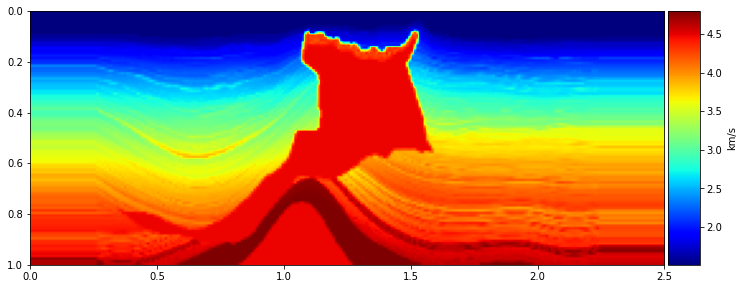

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
nx = np.shape(mat)[1]
nz = np.shape(mat)[0]
dx = 10
par = {'extent': [0, nx*dx/1000, nz*dx/1000, 0]}
plt.figure(figsize=(12,8))
im = plt.imshow(mat/1000,'jet',**par)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); 

<function matplotlib.pyplot.pause(interval)>

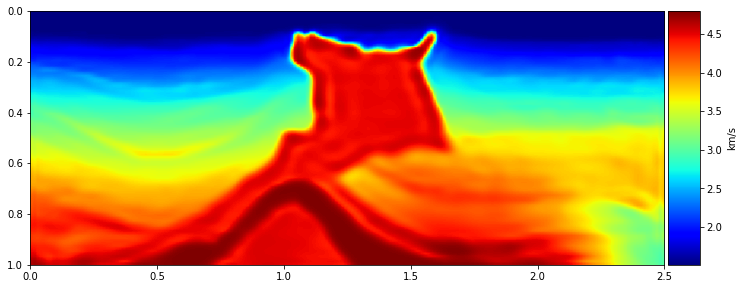

In [17]:
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeNADR20ep1480.npy')
inverted = inverted[0,0,:,:]
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); plt.pause

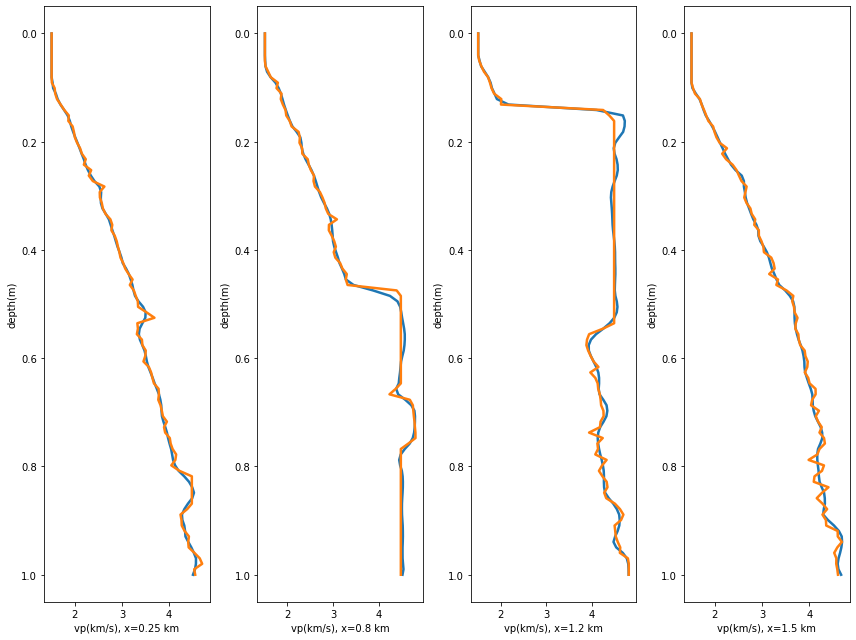

In [161]:
rows = 1
columns = 4
fig1 = plt.figure(figsize=(12,9))

ax = fig1.add_subplot(rows,columns,1)

x = np.linspace(0,nz*dx/1000,100)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,25],x, linewidth=2.5)
plt.plot(mat[:,25]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=0.25 km')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()
#ax.set_ylim(ymin=0)

ax = fig1.add_subplot(rows,columns,2)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,80],x, linewidth=2.5)
plt.plot(mat[:,80]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=0.8 km')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

ax = fig1.add_subplot(rows,columns,3)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,120],x, linewidth=2.5)
plt.plot(mat[:,120]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=1.2 km')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

ax = fig1.add_subplot(rows,columns,4)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(inverted[:,150],x, linewidth=2.5)
plt.plot(mat[:,150]/1000,x, linewidth=2.5)
plt.tight_layout()
plt.xlabel('vp(km/s), x=1.5 km')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()



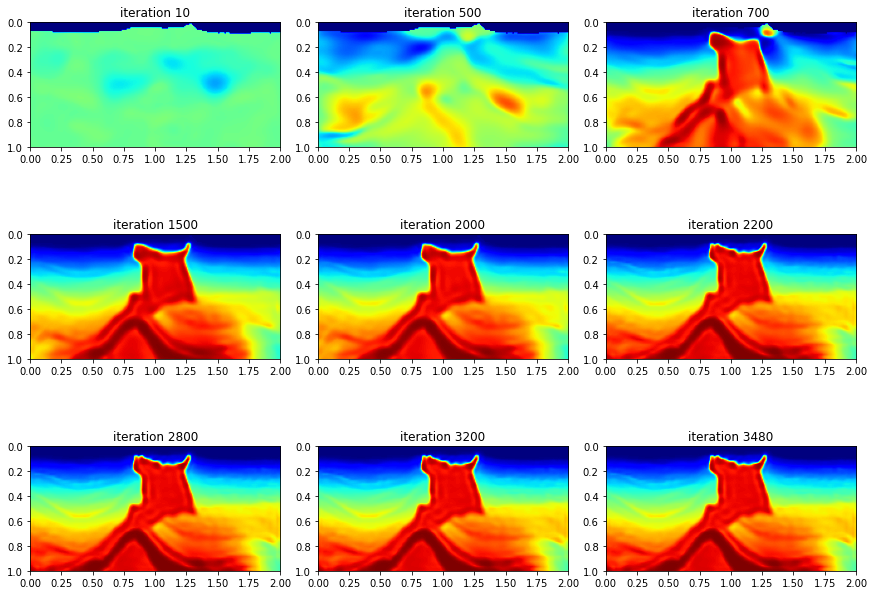

In [65]:
rows = 3
columns = 3
fig1 = plt.figure(figsize=(12,9))

#plt.subplots_adjust(left=0.05, right=0.95, top=0.1)
max1 = np.max(mat/1000)
min1 = np.min(mat/1000)

ax = fig1.add_subplot(rows,columns,1)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeAD0ep10.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 10")


ax = fig1.add_subplot(rows,columns,2)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeAD0ep200.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 500")

ax = fig1.add_subplot(rows,columns,3)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeAD0ep700.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 700")

ax = fig1.add_subplot(rows,columns,4)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeAD0ep1500.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 1500")

#ax = fig1.add_subplot(rows,columns,5)
#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeAD0ep2500.npy')
#im1 = np.squeeze(np.squeeze(im1/1000))
#im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
#ax = plt.gca(); 
#ax.set_title("iteration 2500")

ax = fig1.add_subplot(rows,columns,5)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeAD0ep2000.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 2000")

ax = fig1.add_subplot(rows,columns,6)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeNADR20ep200.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 2200")

#ax = fig1.add_subplot(rows,columns,7)
#im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeNADR20ep1600.npy')
#im1 = np.squeeze(np.squeeze(im1/1000))
#im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
#ax = plt.gca(); 
#ax.set_title("iteration 4600")

ax = fig1.add_subplot(rows,columns,7)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeNADR20ep800.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 2800")

ax = fig1.add_subplot(rows,columns,8)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeNADR20ep1200.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 3200")

ax = fig1.add_subplot(rows,columns,9)
im1 = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/FakeNADR20ep1480.npy')
im1 = np.squeeze(np.squeeze(im1))
im = plt.imshow(im1,'jet',**par,vmin=min1,vmax=max1)
ax = plt.gca(); 
ax.set_title("iteration 3480")

fig1.tight_layout(pad=0.05)

In [115]:
np.max(mat)

4800.0

In [1]:
def plotFakeVelNewStd():
    
    #create figure
    #fig1 = plt.figure(figsize=(9,9))
    #fig2 = plt.figure(figsize=(15,15))
    
    rows = 3
    columns = 3
    matVel = np.zeros((50,1,100,200))
    for k in range(50):
        filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/Output'+str(k)+'/'    
        for i in range(1):
            #fig.add_subplot(rows,columns,i+1)
            #kk=starting+i
            onefile = filename+'150_fake_BT.npy'
            mat=np.load(onefile)
            mat = mat
            matVel[k,i,:,:] = mat
            
    mean = np.mean(matVel,axis=0)
    std = np.std(matVel,axis=0)
    p1 = np.percentile(matVel,5,axis=0)
    q1 = np.percentile(matVel,95,axis=0)
    mean = np.squeeze(mean)
    std = np.squeeze(std)
    p1 = np.squeeze(p1)
    q1 = np.squeeze(q1)
    
    print("mean :", np.shape(mean))
    print("std :", np.shape(std))
    print("p1 :", np.shape(p1))
    print("q1 :", np.shape(q1))
    return mean, std, p1, q1

In [2]:
mean,std,p1,q1 = plotFakeVelNewStd()

NameError: name 'np' is not defined

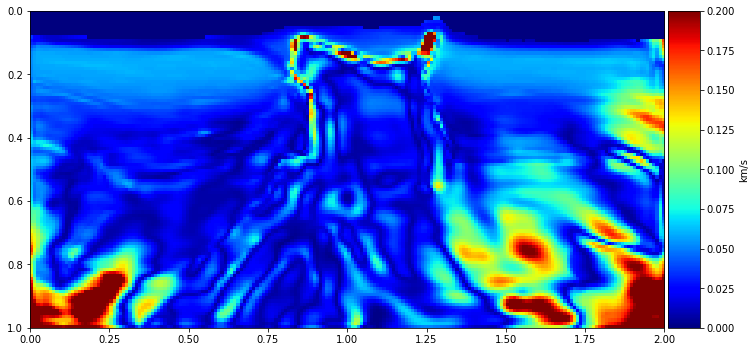

In [88]:
plt.figure(figsize=(12,8))
im = plt.imshow(std,'jet',**par,vmin=0,vmax=0.2)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); 

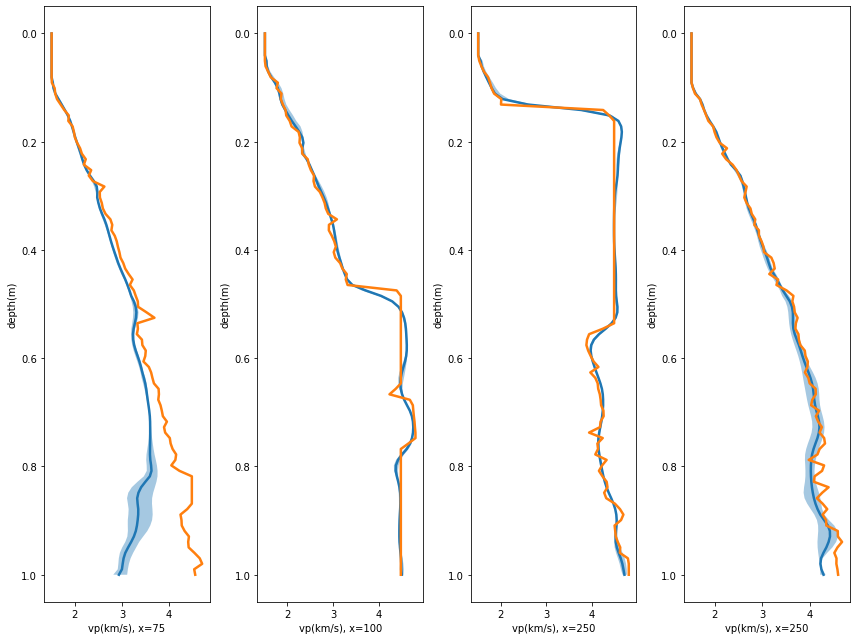

In [111]:
rows = 1
columns = 4
fig1 = plt.figure(figsize=(12,9))

ax = fig1.add_subplot(rows,columns,1)

x = np.linspace(0,nz*dx/1000,100)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,25],x, linewidth=2.5)
plt.plot(mat[:,25]/1000,x, linewidth=2.5)
#plt.plot(p1[:,25],x, linewidth=2.5)
#plt.plot(q1[:,25],x, linewidth=2.5)
#plt.fill_between(x,np.expand_dims(p1[:,25],1),np.expand_dims(q1[:25],1))
pp = p1[:,25]
qq = q1[:,25]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=75')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()
#ax.set_ylim(ymin=0)

ax = fig1.add_subplot(rows,columns,2)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,80],x, linewidth=2.5)
plt.plot(mat[:,80]/1000,x, linewidth=2.5)
#plt.plot(p1[:,80],x, linewidth=2.5)
#plt.plot(q1[:,80],x, linewidth=2.5)
pp = p1[:,80]
qq = q1[:,80]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=100')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

ax = fig1.add_subplot(rows,columns,3)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,120],x, linewidth=2.5)
plt.plot(mat[:,120]/1000,x, linewidth=2.5)
pp = p1[:,120]
qq = q1[:,120]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=250')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

ax = fig1.add_subplot(rows,columns,4)

#x = np.linspace(0,nz*dx/1000,151)
#plt.figure(figsize=(4,10))
plt.plot(mean[:,150],x, linewidth=2.5)
plt.plot(mat[:,150]/1000,x, linewidth=2.5)
pp = p1[:,150]
qq = q1[:,150]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=250')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()


<function matplotlib.pyplot.pause(interval)>

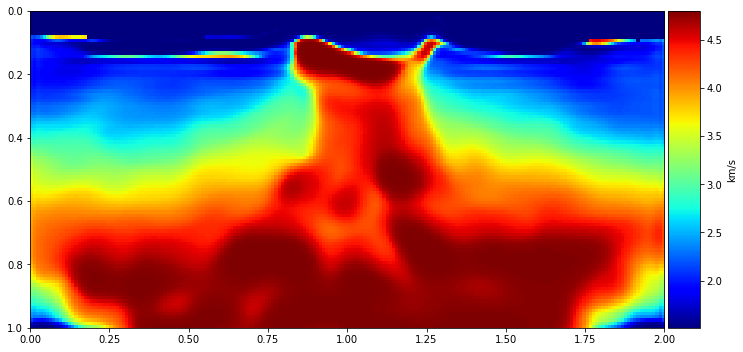

In [158]:
inverted = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi22/Fake4DecAD0ep2120.npy')
inverted = inverted[0,0,:,:]
plt.figure(figsize=(12,8))
im = plt.imshow(inverted,'jet',**par)
ax = plt.gca(); 
divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05); plt.colorbar(im, cax=cax, label='km/s'); plt.pause

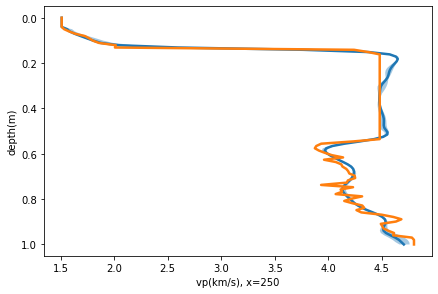

In [113]:
plt.plot(mean[:,120],x, linewidth=2.5)
plt.plot(mat[:,120]/1000,x, linewidth=2.5)
pp = p1[:,120]
qq = q1[:,120]
plt.fill_betweenx(x,pp,qq,alpha=0.4)
plt.tight_layout()
plt.xlabel('vp(km/s), x=250')
plt.ylabel('depth(m)')
ax = plt.gca(); ax.invert_yaxis()

In [39]:
np.shape(B)

(100, 200)

In [40]:
np.shape(C)

(100, 200)

In [41]:
np.max(B)

4800.0

In [82]:
np.min(B)

1510.0

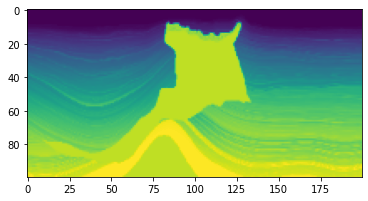

In [83]:
plt.imshow(B)


In [84]:
x_s

tensor([[[   0.0000,    0.0000]],

        [[   0.0000,  117.0588]],

        [[   0.0000,  234.1176]],

        [[   0.0000,  351.1765]],

        [[   0.0000,  468.2353]],

        [[   0.0000,  585.2941]],

        [[   0.0000,  702.3529]],

        [[   0.0000,  819.4117]],

        [[   0.0000,  936.4706]],

        [[   0.0000, 1053.5294]],

        [[   0.0000, 1170.5883]],

        [[   0.0000, 1287.6470]],

        [[   0.0000, 1404.7058]],

        [[   0.0000, 1521.7646]],

        [[   0.0000, 1638.8235]],

        [[   0.0000, 1755.8823]],

        [[   0.0000, 1872.9412]],

        [[   0.0000, 1990.0000]]])

In [126]:
fake = np.load('/disk/student/adhara/Fall2021/PhysicsBasedFWI/marmousi21/FakeAD0ep1500.npy')
fake = np.squeeze(np.squeeze(fake))
model_fake = torch.Tensor(fake*1000)
prop2 = deepwave.scalar.Propagator({'vp': model_fake.to(device)}, dx)
receiver_amplitudes_fake = prop2(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

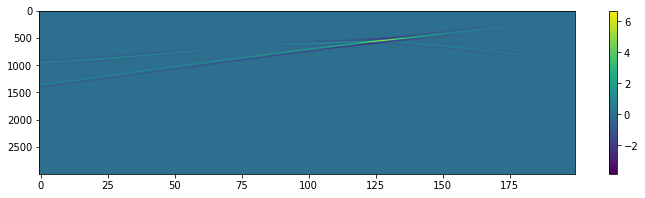

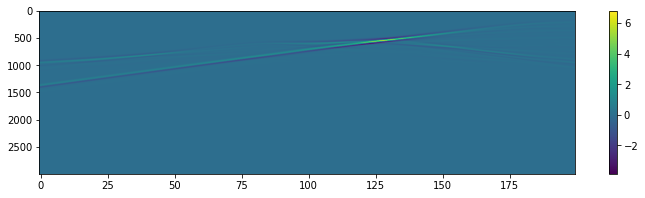

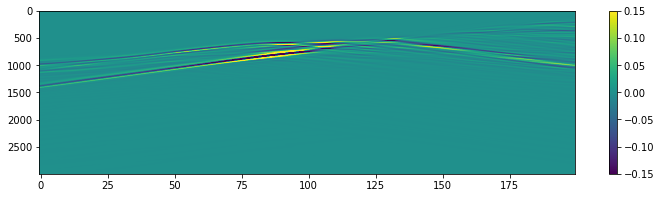

In [129]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_fake[1:3000,17].cpu().detach().numpy()-receiver_amplitudes_cte[1:3000,17].cpu().detach().numpy(),aspect='auto')
    plt.colorbar()
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[1:3000,17].cpu().detach().numpy()-receiver_amplitudes_cte[1:3000,17].cpu().detach().numpy(),aspect='auto')
    plt.colorbar()
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_fake[1:3000,17].cpu().detach().numpy()-receiver_amplitudes_all[1:3000,17].cpu().detach().numpy(),vmin=-0.15,vmax=0.15,aspect='auto')
    plt.colorbar()

    #plt.title('Model seismogram w direct waves removed')

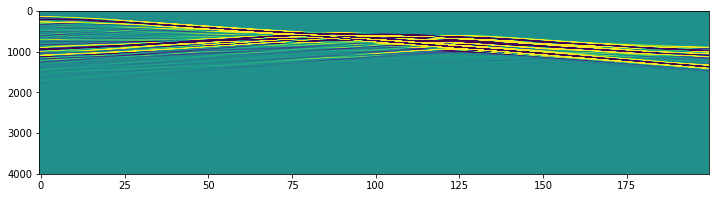

In [118]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_fake[:,0].cpu().detach().numpy()-receiver_amplitudes_all[:,0].cpu().detach().numpy(),vmin=-.01,vmax=.01, aspect='auto')
    #plt.colorbar()
    #plt.title('Model seismogram w direct waves removed')

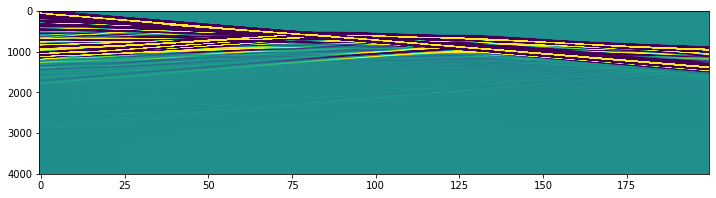

In [103]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,0].cpu().detach().numpy(),vmin=-.01,vmax=.01, aspect='auto')
    #plt.colorbar()
    #plt.title('Model seismogram w direct waves removed')

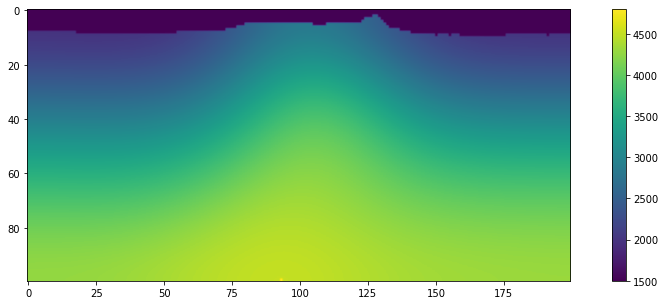

In [123]:
plt.figure(figsize=(15, 5))
plt.imshow(np.squeeze(mat3),vmin=1500,vmax=4800, aspect=1)
plt.colorbar()

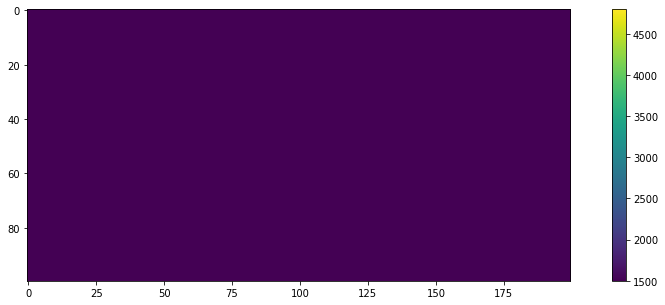

In [131]:
plt.figure(figsize=(15, 5))
plt.imshow(np.ones(np.shape(np.squeeze(mat3)))*1500,vmin=1500,vmax=4800, aspect=1)
plt.colorbar()